In [1]:
import praw
import pandas as pd
import datetime as dt
import time

# Initialize Reddit API (Replace with your credentials)
reddit = praw.Reddit(
    client_id='K5eClhs10PzsecZNXB-h2Q',
    client_secret='4iKyc6eLa8xf2gN4es6sl0hv9gL-Bw',
    user_agent='your_user_agent'
)

def fetch_relevant_posts(subreddits, keywords, start_date, limit=1000):
    """Fetch relevant posts using PRAW's search, with a 5-minute wait between subreddits."""
    posts = []
    start_timestamp = int(dt.datetime.strptime(start_date, "%Y-%m-%d").timestamp())

    for subreddit in subreddits:
        print(f"Fetching posts from r/{subreddit}...")

        try:
            for post in reddit.subreddit(subreddit).search(" OR ".join(keywords), sort="new", time_filter="all", limit=limit):
                if post.created_utc < start_timestamp:
                    continue  # Ignore older posts
                
                # Fetch comments
                post.comments.replace_more(limit=0)
                comments = [comment.body for comment in post.comments[:100]]  # Top 100 comments
                comments_text = " ||| ".join(comments)

                posts.append([
                    subreddit,
                    post.title,
                    post.selftext,
                    post.score,
                    post.num_comments,
                    dt.datetime.fromtimestamp(post.created_utc),
                    post.url,
                    comments_text
                ])
                time.sleep(1)  # Rate-limiting per post

        except Exception as e:
            print(f"Error fetching data from r/{subreddit}: {e}")

        print(f"Finished fetching from r/{subreddit}. Waiting before moving to the next subreddit...")
        time.sleep(100)  

    return pd.DataFrame(posts, columns=['subreddit', 'title', 'body', 'score', 'num_comments', 'timestamp', 'url', 'comments'])

def save_to_csv(df, filename='reddit_posts.csv'):
    """Save the DataFrame to a CSV file."""
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} posts to {filename}")

# Example usage
if __name__ == "__main__":
    subreddits = ['IndianStockMarket', 'IndiaInvestments', 'StockMarketIndia', 'IndianStreetBets', 'stocks', 'investing', 'financialindependence']
    keywords = ['Reliance', 'Tata', 'Infosys', 'HDFC', 'Nifty', 'ICICI', 'Wipro', 'Adani', 'Maruti', 'Larsen']
    start_date = (dt.datetime.now() - dt.timedelta(days=16*365)).strftime('%Y-%m-%d')  # 16 years ago
    
    reddit_df = fetch_relevant_posts(subreddits, keywords, start_date, limit=3000)  
    save_to_csv(reddit_df)


Fetching posts from r/IndianStockMarket...
Finished fetching from r/IndianStockMarket. Waiting before moving to the next subreddit...
Fetching posts from r/IndiaInvestments...
Finished fetching from r/IndiaInvestments. Waiting before moving to the next subreddit...
Fetching posts from r/StockMarketIndia...
Finished fetching from r/StockMarketIndia. Waiting before moving to the next subreddit...
Fetching posts from r/IndianStreetBets...
Finished fetching from r/IndianStreetBets. Waiting before moving to the next subreddit...
Fetching posts from r/stocks...
Finished fetching from r/stocks. Waiting before moving to the next subreddit...
Fetching posts from r/investing...
Finished fetching from r/investing. Waiting before moving to the next subreddit...
Fetching posts from r/financialindependence...
Finished fetching from r/financialindependence. Waiting before moving to the next subreddit...
Saved 1443 posts to reddit_posts.csv


In [ ]:
import yfinance as yf
import pandas as pd
import datetime as dt

# Function to fetch historical stock data for a given period
def fetch_stock_data(tickers, start_date, end_date):
    """Fetch historical stock data from Yahoo Finance."""
    all_data = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        if not data.empty:
            data.reset_index(inplace=True)
            data['Ticker'] = ticker  # Add ticker column
            all_data.append(data)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])

# Function to save stock data to CSV
def save_to_csv(df, filename='stock_data.csv'):
    """Save the DataFrame to a CSV file."""
    df.to_csv(filename, index=False)

# Example usage
if __name__ == "__main__":
    # Define stock tickers matching Reddit discussion
    tickers = ['RELIANCE.NS', 'TATASTEEL.NS', 'INFY.NS', 'HDFCBANK.NS', '^NSEI',
               'ICICIBANK.NS', 'WIPRO.NS', 'ADANIENT.NS', 'MARUTI.NS', 'LT.NS']
    
    # Define time range (past 15 years)
    end_date = dt.datetime.now().strftime('%Y-%m-%d')
    start_date = (dt.datetime.now() - dt.timedelta(days=16*365)).strftime('%Y-%m-%d')  # 16 years ago
    
    stock_df = fetch_stock_data(tickers, start_date, end_date)
    save_to_csv(stock_df)
    
    print("Saved stock data for", len(tickers), "stocks to stock_data.csv")


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    """Preprocess text by removing URLs, special characters, and stopwords."""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    
    tokens = word_tokenize(text)  # Tokenize text
    filtered_text = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    
    return ' '.join(filtered_text)

def preprocess_reddit_data(filename='reddit_posts.csv', output_filename='cleaned_reddit_posts.csv'):
    """Load, clean, and save the preprocessed Reddit post data."""
    df = pd.read_csv(filename)
    df['cleaned_title'] = df['title'].apply(clean_text)
    df['cleaned_body'] = df['body'].apply(clean_text)
    df['cleaned_comments'] = df['comments'].apply(clean_text)
    
    df.to_csv(output_filename, index=False)
    print(f"Preprocessed data saved to {output_filename}")

# Example usage
if __name__ == "__main__":
    preprocess_reddit_data()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell.000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocessed data saved to cleaned_reddit_posts.csv


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import torch
from collections import defaultdict

# Load Reddit data
df = pd.read_csv('cleaned_reddit_posts.csv')

# Ensure timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['Date'] = df['timestamp'].dt.date  # Truncate to daily resolution

# Load FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define sentiment analyzer that removes neutral and returns binary sentiment
def get_sentiment_label(text):
    if isinstance(text, str) and text.strip():
        inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)[0]
        labels = model.config.id2label
        label_score_pairs = [(labels[i], float(scores[i])) for i in range(len(scores))]
        top_label, top_score = max(label_score_pairs, key=lambda x: x[1])
        if top_label == "Neutral":
            return "Positive" if top_score >= 0.65 else "Negative"
        return top_label
    return "Negative"

# Apply sentiment analysis with progress bar
tqdm.pandas()
df['sentiment'] = df['comments'].progress_apply(get_sentiment_label)

# Group by Date and Subreddit to extract sentiment counts and volume
sentiment_summary = (
    df.groupby(['Date', 'subreddit'])['sentiment']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Rename columns
sentiment_summary.rename(columns={
    'Positive': 'count_positive',
    'Negative': 'count_negative'
}, inplace=True)

# Total posts and ratio
sentiment_summary['count_total'] = sentiment_summary['count_positive'] + sentiment_summary['count_negative']
sentiment_summary['positive_ratio'] = sentiment_summary['count_positive'] / sentiment_summary['count_total'].replace(0, 1)
sentiment_summary['activity_count'] = sentiment_summary['count_total']

# Save refined sentiment dataset
sentiment_summary.to_csv('refined_reddit_sentiment_summary.csv', index=False)
print("Refined sentiment features extracted and saved.")


Device set to use cpu
100%|██████████| 1443/1443 [26:08<00:00,  1.09s/it]

Refined sentiment features extracted and saved.


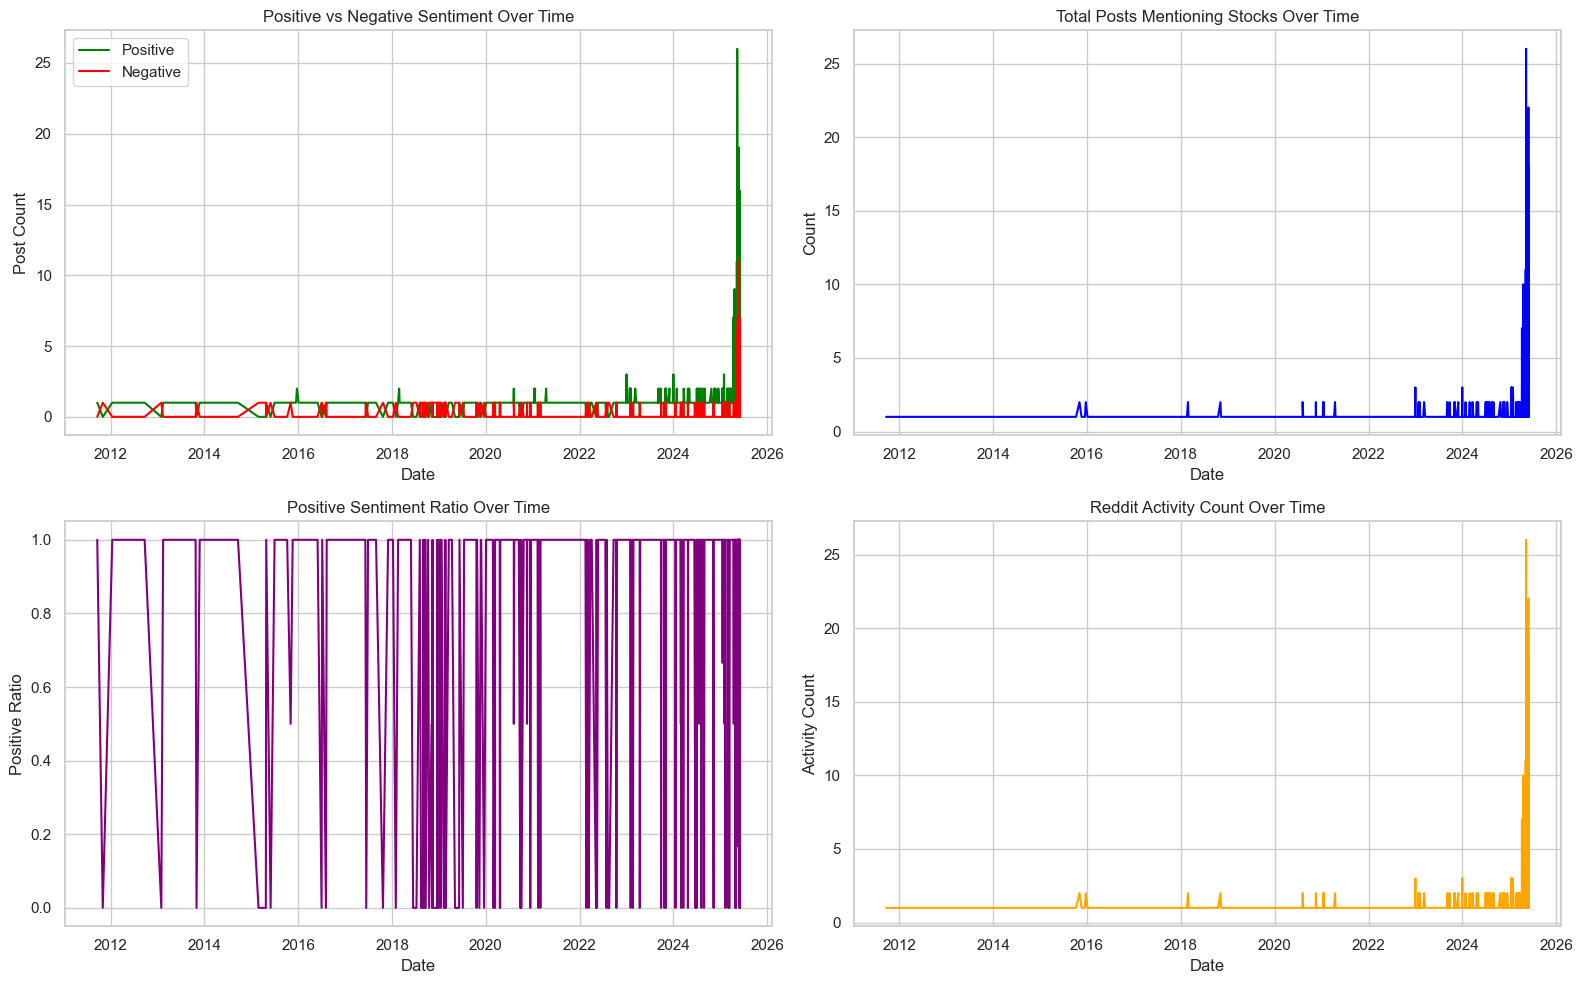

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load sentiment data
df = pd.read_csv("refined_reddit_sentiment_summary.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)

# Set plot style
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(16, 10))

# Subplot 1: Positive and Negative Count Over Time
plt.subplot(2, 2, 1)
plt.plot(df["Date"], df["count_positive"], label="Positive", color='green')
plt.plot(df["Date"], df["count_negative"], label="Negative", color='red')
plt.title("Positive vs Negative Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.legend()

# Subplot 2: Total Posts Over Time
plt.subplot(2, 2, 2)
plt.plot(df["Date"], df["count_total"], color='blue')
plt.title("Total Posts Mentioning Stocks Over Time")
plt.xlabel("Date")
plt.ylabel("Count")

# Subplot 3: Positive Ratio Over Time
plt.subplot(2, 2, 3)
plt.plot(df["Date"], df["positive_ratio"], color='purple')
plt.title("Positive Sentiment Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Positive Ratio")

# Subplot 4: Activity Count Over Time
plt.subplot(2, 2, 4)
plt.plot(df["Date"], df["activity_count"], color='orange')
plt.title("Reddit Activity Count Over Time")
plt.xlabel("Date")
plt.ylabel("Activity Count")

plt.tight_layout()
plt.show()


In [60]:
import pandas as pd

# Load stock data CSV
stock_df = pd.read_csv("stock_data.csv", parse_dates=["Date"])

# Function to add technical indicators
def add_technical_indicators(df):
    df = df.copy()
    df["SMA_14"] = df["Close"].rolling(window=14).mean()
    df["EMA_14"] = df["Close"].ewm(span=14, adjust=False).mean()

    # RSI calculation
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # MACD and MACD Signal
    ema_12 = df["Close"].ewm(span=12, adjust=False).mean()
    ema_26 = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = ema_12 - ema_26
    df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD_diff"] = df["MACD"] - df["MACD_signal"]

    # Bollinger Bands
    rolling_mean = df["Close"].rolling(window=20).mean()
    rolling_std = df["Close"].rolling(window=20).std()
    df["BB_Upper"] = rolling_mean + (rolling_std * 2)
    df["BB_Lower"] = rolling_mean - (rolling_std * 2)

    # Momentum over 10 days
    df["Momentum_10"] = df["Close"].diff(10)

    # On-Balance Volume (OBV)
    obv = [0]
    for i in range(1, len(df)):
        if df["Close"].iloc[i] > df["Close"].iloc[i-1]:
            obv.append(obv[-1] + df["Volume"].iloc[i])
        elif df["Close"].iloc[i] < df["Close"].iloc[i-1]:
            obv.append(obv[-1] - df["Volume"].iloc[i])
        else:
            obv.append(obv[-1])
    df["OBV"] = obv

    return df

# Add indicators
stock_df_with_indicators = add_technical_indicators(stock_df)

# Save to new CSV
stock_df_with_indicators.to_csv("stock_data_with_indicators.csv", index=False)

print("Technical indicators added and saved to 'stock_data_with_indicators.csv'")


Technical indicators added and saved to 'stock_data_with_indicators.csv'


In [ ]:
import pandas as pd

# Load and process stock data
stock_df = pd.read_csv("stock_data_with_indicators.csv", parse_dates=["Date"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.tz_localize(None).dt.normalize()

# Load and process reddit data
reddit_df = pd.read_csv("refined_reddit_sentiment_summary.csv", parse_dates=["Date"])
reddit_df["Date"] = pd.to_datetime(reddit_df["Date"]).dt.tz_localize(None).dt.normalize()

# DEBUG: Print dtypes to verify
print("Stock Date dtype:", stock_df["Date"].dtype)
print("Reddit Date dtype:", reddit_df["Date"].dtype)

# Merge
merged_df = pd.merge(stock_df, reddit_df, on="Date", how="inner")

# Save merged data
merged_df.to_csv("merged_stock_sentiment_data.csv", index=False)

print("Merge successful. File saved.")


Stock Date dtype: datetime64[ns]
Reddit Date dtype: datetime64[ns]
 Merge successful. File saved.


In [117]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configs
SEQ_LEN = 30
BATCH_SIZE = 64
EPOCHS = 50
LR = 0.01
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TARGET_COL = 'Close'

# === Load Data ===
df = pd.read_csv("merged_stock_sentiment_data.csv")  # Replace with your CSV path

# === Fix dtypes and clean ===
numeric_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_diff',
    'BB_Upper', 'BB_Lower', 'Momentum_10', 'OBV',
    'count_negative', 'count_positive', 'count_total', 'positive_ratio', 'activity_count'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=numeric_cols + [TARGET_COL]).reset_index(drop=True)

# === Scale features ===
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[numeric_cols])
scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# === Dataset ===
class StockDataset(Dataset):
    def __init__(self, data, seq_len, target_col='Close'):
        self.sequences = []
        self.target_col = target_col
        self.seq_len = seq_len
        values = data.values
        for i in range(len(values) - seq_len):
            x = values[i:i + seq_len, :]
            y = values[i + seq_len, numeric_cols.index(target_col)]
            self.sequences.append((x.astype(np.float32), float(y)))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x, y = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = StockDataset(scaled_df, SEQ_LEN)
train_size = int(0.8 * len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=len(numeric_cols)).to(DEVICE)

# === Loss, Optimizer, Scheduler ===
criterion = nn.HuberLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# === Training ===
for epoch in range(EPOCHS):
    model.train()
    train_losses = []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        output = model(x_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            val_output = model(x_val).squeeze()
            val_loss = criterion(val_output, y_val)
            val_losses.append(val_loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# === Inference (on validation set) ===
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for x_val, y_val in val_loader:
        x_val = x_val.to(DEVICE)
        output = model(x_val).squeeze().cpu().numpy()
        predictions.extend(output)
        actuals.extend(y_val.numpy())


C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Train Loss: 0.0027, Val Loss: 0.0004
Epoch 2/50, Train Loss: 0.0005, Val Loss: 0.0003
Epoch 3/50, Train Loss: 0.0004, Val Loss: 0.0002
Epoch 4/50, Train Loss: 0.0004, Val Loss: 0.0002
Epoch 5/50, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 6/50, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 7/50, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 8/50, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 9/50, Train Loss: 0.0003, Val Loss: 0.0014
Epoch 10/50, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 11/50, Train Loss: 0.0003, Val Loss: 0.0001
Epoch 12/50, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 13/50, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 14/50, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 15/50, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 16/50, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 17/50, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 18/50, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 19/50, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 20/50, Train Loss: 0.0002, Val Loss: 0.0000
Epoch 21/

In [120]:
import warnings
from sklearn.exceptions import DataConversionWarning
import torch
import numpy as np

# Suppress sklearn warnings about feature names
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Assuming your scaler, model, df, numeric_cols, SEQ_LEN, DEVICE, and scaled_df are already defined and loaded

model.eval()
ticker_predictions = {}
target_col_index = list(scaled_df.columns).index('Close')

tickers = df['Ticker'].unique()

for ticker in tickers:
    ticker_df = df[df['Ticker'] == ticker].copy()

    if len(ticker_df) < SEQ_LEN:
        print(f"Skipping {ticker}: not enough data")
        continue

    ticker_df[numeric_cols] = ticker_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    ticker_df = ticker_df.dropna(subset=numeric_cols)

    if len(ticker_df) < SEQ_LEN:
        print(f"Skipping {ticker}: insufficient clean data")
        continue

    last_30 = ticker_df[numeric_cols].tail(SEQ_LEN).values
    last_30_scaled = scaler.transform(last_30).astype(np.float32)
    input_seq = torch.tensor(last_30_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        pred = model(input_seq).item()

    # Inverse transform only the predicted Close price
    dummy_input = np.zeros((1, scaled_df.shape[1]))
    dummy_input[0, target_col_index] = pred
    original_scale = scaler.inverse_transform(dummy_input)[0, target_col_index]

    ticker_predictions[ticker] = original_scale

print("\n📈 Corrected Next-day Close Price Predictions:")
for ticker, price in ticker_predictions.items():
    print(f"{ticker}: ₹{price:.2f}")



📈 Corrected Next-day Close Price Predictions:
RELIANCE.NS: ₹1359.50
TATASTEEL.NS: ₹192.04
INFY.NS: ₹1466.85
HDFCBANK.NS: ₹1902.69
^NSEI: ₹19420.10
ICICIBANK.NS: ₹1439.05
WIPRO.NS: ₹258.82
ADANIENT.NS: ₹2299.20
MARUTI.NS: ₹10729.85
LT.NS: ₹3232.79


C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWa

In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

model.eval()

true_vals = []
pred_vals = []

tickers = df['Ticker'].unique()

for ticker in tickers:
    ticker_df = df[df['Ticker'] == ticker].copy()

    if len(ticker_df) < SEQ_LEN:
        continue

    ticker_df[numeric_cols] = ticker_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    ticker_df = ticker_df.dropna(subset=numeric_cols)

    if len(ticker_df) < SEQ_LEN:
        continue

    # Prepare input sequence
    X = ticker_df[numeric_cols].tail(SEQ_LEN).values
    y_true = ticker_df['Close'].iloc[-1]  # True next day close price

    X_scaled = scaler.transform(X).astype(np.float32)
    input_seq = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        y_pred_scaled = model(input_seq).item()

    # Inverse transform prediction to original scale
    dummy_input = np.zeros((1, scaled_df.shape[1]))
    target_col_index = list(scaled_df.columns).index('Close')
    dummy_input[0, target_col_index] = y_pred_scaled
    y_pred = scaler.inverse_transform(dummy_input)[0, target_col_index]

    true_vals.append(y_true)
    pred_vals.append(y_pred)

# Calculate metrics
mae = mean_absolute_error(true_vals, pred_vals)
mse = mean_squared_error(true_vals, pred_vals)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, pred_vals)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 673.3935
Mean Squared Error (MSE): 2649910.0585
Root Mean Squared Error (RMSE): 1627.8544
R-squared (R²): 0.9500


C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWa

In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import torch

SEQ_LEN = 30  # Adjust to your sequence length
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

ticker_metrics = {}

tickers = df['Ticker'].unique()

for ticker in tickers:
    ticker_df = df[df['Ticker'] == ticker].copy()
    ticker_df[numeric_cols] = ticker_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    ticker_df = ticker_df.dropna(subset=numeric_cols)
    
    if len(ticker_df) < SEQ_LEN + 1:
        print(f"Skipping {ticker}: not enough data")
        continue
    
    true_vals = []
    preds = []

    # Loop over time to get rolling predictions
    for i in range(len(ticker_df) - SEQ_LEN):
        window = ticker_df[numeric_cols].iloc[i:i+SEQ_LEN].values
        true_close = ticker_df['Close'].iloc[i + SEQ_LEN]

        # Scale input window
        window_scaled = scaler.transform(window).astype(np.float32)
        input_seq = torch.tensor(window_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_scaled = model(input_seq).item()

        # Inverse transform prediction to original scale (only Close column)
        dummy = np.zeros((1, len(numeric_cols)))
        target_col_index = numeric_cols.index('Close')
        dummy[0, target_col_index] = pred_scaled
        pred_orig = scaler.inverse_transform(dummy)[0, target_col_index]

        true_vals.append(true_close)
        preds.append(pred_orig)

    if len(true_vals) == 0:
        print(f"No predictions made for {ticker}")
        continue

    mae = mean_absolute_error(true_vals, preds)
    mse = mean_squared_error(true_vals, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, preds)

    ticker_metrics[ticker] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Print metrics
for ticker, metrics in ticker_metrics.items():
    print(f"Metrics for {ticker}:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R2: {metrics['R2']:.4f}\n")


C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWa

Metrics for RELIANCE.NS:
  MAE: 33.6130
  MSE: 2044.7175
  RMSE: 45.2186
  R2: 0.9812

Metrics for TATASTEEL.NS:
  MAE: 26.8562
  MSE: 1228.5108
  RMSE: 35.0501
  R2: 0.6009

Metrics for INFY.NS:
  MAE: 40.6484
  MSE: 3090.5484
  RMSE: 55.5927
  R2: 0.9840

Metrics for HDFCBANK.NS:
  MAE: 38.8917
  MSE: 2766.0448
  RMSE: 52.5932
  R2: 0.9697

Metrics for ^NSEI:
  MAE: 318.8658
  MSE: 287697.0177
  RMSE: 536.3740
  R2: 0.9889

Metrics for ICICIBANK.NS:
  MAE: 28.0685
  MSE: 1439.4298
  RMSE: 37.9398
  R2: 0.9887

Metrics for WIPRO.NS:
  MAE: 27.1525
  MSE: 1283.1978
  RMSE: 35.8217
  R2: 0.6727

Metrics for ADANIENT.NS:
  MAE: 93.9243
  MSE: 30365.7129
  RMSE: 174.2576
  R2: 0.9783

Metrics for MARUTI.NS:
  MAE: 248.0575
  MSE: 133124.7565
  RMSE: 364.8627
  R2: 0.9757

Metrics for LT.NS:
  MAE: 65.7597
  MSE: 7828.7896
  RMSE: 88.4804
  R2: 0.9928



C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dell.000\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWa

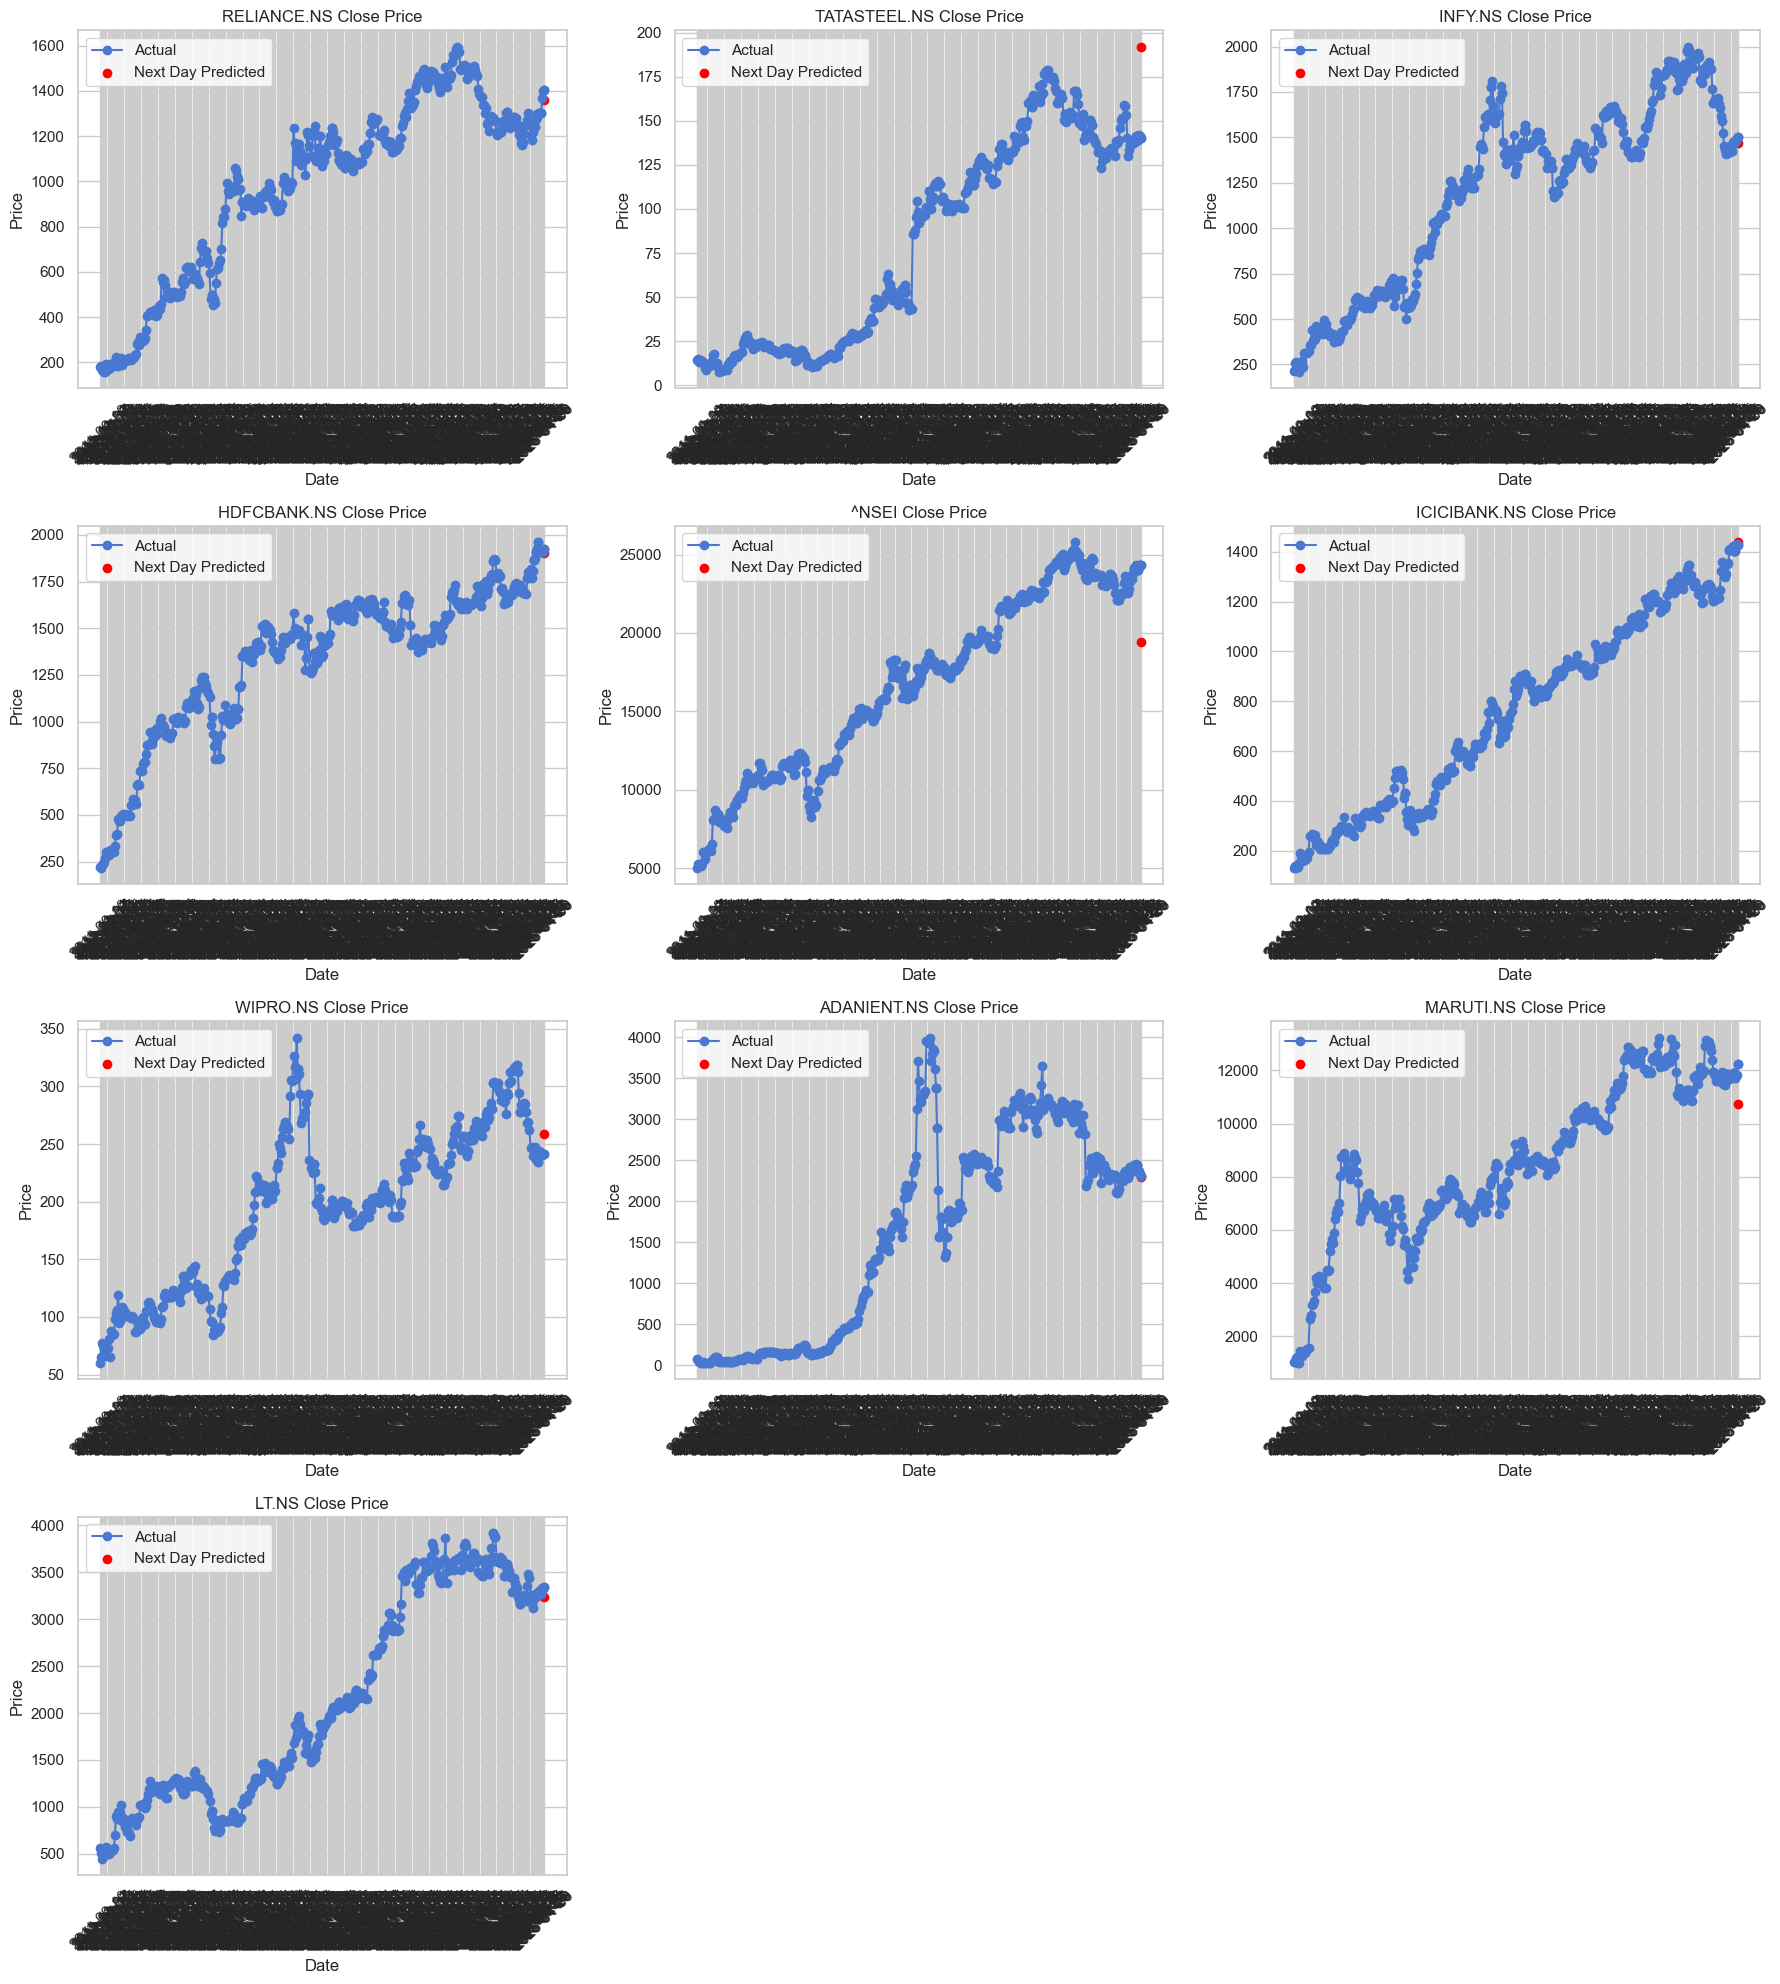

In [132]:
import matplotlib.pyplot as plt

tickers = df['Ticker'].unique()
num_tickers = len(tickers)
cols = 3  # number of columns in the plot grid
rows = (num_tickers + cols - 1) // cols  # ceiling division for rows

plt.figure(figsize=(18, 5 * rows))

for i, ticker in enumerate(tickers, 1):
    ticker_df = df[df['Ticker'] == ticker].copy()
    
    # Make sure ticker_df is sorted by date
    ticker_df = ticker_df.sort_values('Date')
    
    # Extract actual Close prices and predicted Close prices
    actual = ticker_df['Close'].values
    
    # For predictions, you must have a series/array aligned with actual dates
    # Here, I assume you have predictions for each ticker for the same date range in `predictions[ticker]`
    # If you only have one prediction, you might want to plot that as a point or just skip
    pred = ticker_predictions.get(ticker, None)
    
    # If ticker_predictions has just a scalar (next day), you can skip or just plot last actual + prediction point
    # Let's assume you have predictions for all dates stored in a dict 'all_preds' keyed by ticker, with arrays
    
    # For demonstration, let's plot actual and predicted as lines if both available
    # Replace this with your actual prediction series if available
    predicted_series = ticker_df.get('Predicted_Close', None)  # if you saved predictions in df
    
    plt.subplot(rows, cols, i)
    plt.plot(ticker_df['Date'], actual, label='Actual', marker='o')
    
    if predicted_series is not None:
        plt.plot(ticker_df['Date'], predicted_series, label='Predicted', marker='x')
    else:
        # If only one scalar prediction for next day close exists:
        plt.scatter(ticker_df['Date'].iloc[-1], pred, color='red', label='Next Day Predicted')
    
    plt.title(f"{ticker} Close Price")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
